# In this notebook we will map rsfMRI data to a hippocampal surface, and then visualize it

NOTE: this tutorial assumes you have tools like `FSL`, `ANTs`, `AFNI`, and `wb_command` already in your bash `PATH`.\
We will assume hippunfold was run on the native T1w image. For Micapipe this is referred to as `space-nativepro`.

## The first step will thus be to resample fMRI data into `space-nativepro`:
(see https://micapipe.readthedocs.io/en/latest/pages/04.faq/index.html#registration-issues)

In [3]:
# set up a test subject
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe'
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.0.0'
subject = 'HC002'
hemi = 'L'

!mkdir tmp # make a temporary directory for storing files

In [4]:
# get resolution of rsfMRI image so we can maintain that resolution
rsfmri = f'{micapipe_dir}/sub-{subject}/ses-01/func/volumetric/sub-{subject}_ses-01_space-rsfmri_desc-singleecho_clean.nii.gz'
cmd = f'fslinfo {rsfmri}'
headerinfo = !{cmd}
resolution = headerinfo[6].split()[1], headerinfo[7].split()[1], headerinfo[8].split()[1]

In [5]:
# make a downsampled T1w as reference
cmd = f'3dresample -dxyz {resolution[0]} {resolution[1]} {resolution[2]} -rmode Linear '\
    f'-input {micapipe_dir}/sub-{subject}/ses-01/anat/sub-{subject}_ses-01_space-nativepro_t1w.nii.gz '\
    f'-prefix tmp/sub-{subject}_ses-01_space-nativepro_t1w_downsampledRef.nii.gz'
!{cmd}

*+ WARNING:   If you are performing spatial transformations on an oblique dset,
  such as /data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC002/ses-01/anat/sub-HC002_ses-01_space-nativepro_t1w.nii.gz,
  or viewing/combining it with volumes of differing obliquity,
  you should consider running: 
     3dWarp -deoblique 
  on this and  other oblique datasets in the same session.
 See 3dWarp -help for details.
++ Oblique dataset:/data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC002/ses-01/anat/sub-HC002_ses-01_space-nativepro_t1w.nii.gz is 2.944638 degrees from plumb.


In [6]:
# transform func to nativepro (downsampled)
cmd = f'antsApplyTransforms -d 3 -e 3 -v '\
    f'-i {micapipe_dir}/sub-{subject}/ses-pre-01/func/volumetric/sub-{subject}_ses-pre-01_space-rsfmri_desc-singleecho_clean.nii.gz '\
    f'-r /data_/mica1/01_programs/micapipe/MNI152Volumes/MNI152_T1_2mm_brain.nii.gz '\
    f'-o tmp/sub-{subject}_ses-pre-01_space-nativepro_rsfmri.nii.gz '\
    f'-t {micapipe_dir}/sub-{subject}/ses-pre-01/xfm/sub-{subject}_ses-pre-01_from-nativepro_brain_to-MNI152_2mm_mode-image_desc-SyN_1Warp.nii.gz '\
    f'-t {micapipe_dir}/sub-{subject}/ses-pre-01/xfm/sub-{subject}_ses-pre-01_from-nativepro_brain_to-MNI152_2mm_mode-image_desc-SyN_0GenericAffine.mat '\
    f'-t {micapipe_dir}/sub-{subject}/ses-pre-01/xfm/sub-{subject}_ses-pre-01_rsfmri_from-rsfmri_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
    f'-t [{micapipe_dir}/sub-{subject}/ses-pre-01/xfm/sub-{subject}_ses-pre-01_rsfmri_from-nativepro_rsfmri_to-rsfmri_mode-image_desc-SyN_0GenericAffine.mat,1] '\
    f'-t {micapipe_dir}/sub-{subject}/ses-pre-01/xfm/sub-{subject}_ses-pre-01_rsfmri_from-nativepro_rsfmri_to-rsfmri_mode-image_desc-SyN_1InverseWarp.nii.gz '
!{cmd}

Note it is best to check that these files are properly aligned by opening them in a viewer like Freeview.

## Now we are ready to sample this data along a hippocampal surface:

In [7]:
cmd = f'wb_command -volume-to-surface-mapping '\
    f'tmp/sub-{subject}_ses-01_space-nativepro_rsfmri.nii.gz '\
    f'{hippunfold_dir}/hippunfold/sub-{subject}/surf/sub-{subject}_hemi-{hemi}_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii '\
    f'tmp/sub-{subject}_hemi-{hemi}_space-T1w_den-0p5mm_rsmfri.func.gii '\
    f'-enclosing'
!{cmd}

## Now lets load the surface data and have a look:

/export03/data/opt/hippunfold_toolbox/Python/plotting.py:117: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cdata=='fill':


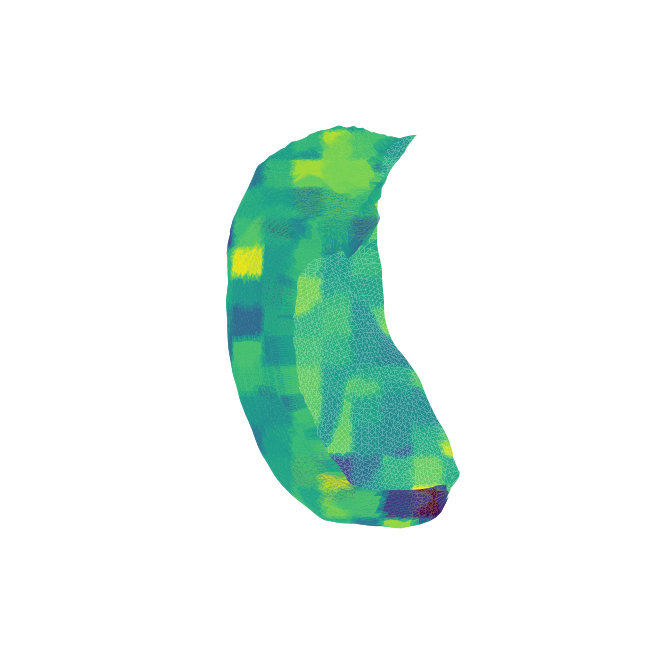

In [8]:
import plotting as hu
import nibabel as nib

surface = nib.load(f'{hippunfold_dir}/hippunfold/sub-{subject}/surf/sub-{subject}_hemi-{hemi}_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii')
func = nib.load(f'tmp/sub-{subject}_hemi-{hemi}_space-T1w_den-0p5mm_rsmfri.func.gii')

# plot only the very first timepoint
fig,ax = hu.plot_gifti(surface,func.darrays[0].data)
ax.view_init(elev=90, azim=-90)

/export03/data/opt/hippunfold_toolbox/Python/plotting.py:83: UserWarning: Attempting to set identical bottom == top == 1.171875 results in singular transformations; automatically expanding.
  ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])


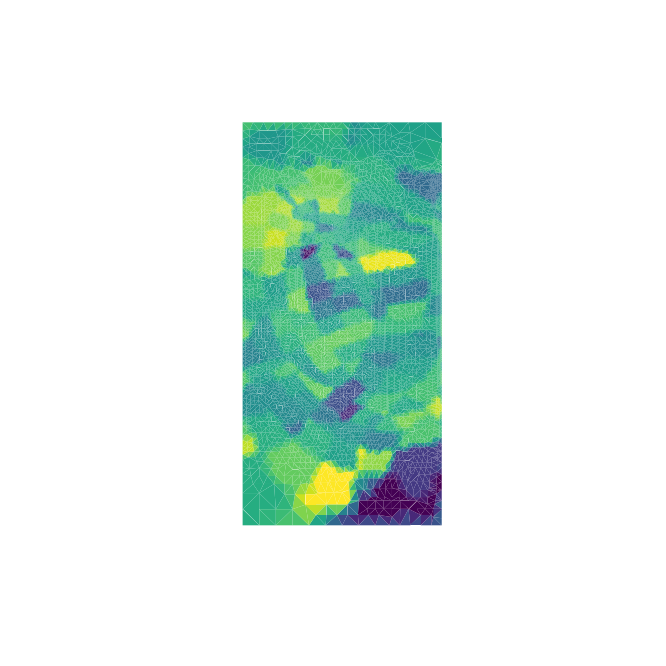

In [9]:
# plot on an unfolded surface
surface_unfolded = nib.load(f'{hippunfold_dir}/hippunfold/sub-{subject}/surf/sub-{subject}_hemi-{hemi}_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii')
fig,ax = hu.plot_gifti(surface_unfolded,func.darrays[0].data)
ax.view_init(elev=-90, azim=0)


This code can be looped over all subjects, and can be run on different features. For example, instead of an fMRI image, we could transform and sample a DWI image. 

All hippunfold subjects have corresponding vertices, meaning that we could load and average across subjects WHERE APPROPRIATE - we wouldn't do this for rsfMRI since subjects may be thinking of different things at different times. We could consider doing this for a time-locked experiment like movie watching, or, we could average across subjects for each vertex for a structural measure like Fractional Anisotropy (FA) derived from DWI. 

We could consider running an expierment where we compare FA measures across two groups at each vertex. This is more precise than other methods since vertices are carefully aligned between subjects according to their topology in HippUnfold. We could also find the subset of vertices belonging to a given subfield using (for example) the `sub-HC002_hemi-L_space-T1w_den-0p5mm_label-hipp_subfields.label.gii` HippUnfold output file. Averaging data within one of these ROIs may help improve signal-to-noise ratio, at the cost of no longer being able to check for anterior-posterior differences. Alternatively, we could parametrically test whether data aligns with the anterior-posterior axis by correlating it with the unfolded y axis. 